## Interpolación de valores faltantes

Primero cargamos la información y limpiamos los datos, así ocmo calcular las variables necesarias. 

In [2]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

ruta_guardado = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\data_lake\PKL\dfs_final.pkl"

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
with open(ruta_guardado, 'rb') as f:
    dfs_final = pickle.load(f)

In [5]:
dfs = dfs_final

In [6]:
athletes_df = dfs['athletes_df']
athletes_events_df = dfs['athletes_events_df']
athletes_time_df = dfs['athletes_time_df']

issues_df = dfs['issues_df']
issues_events_df = dfs['issues_events_df']
issues_data_df = dfs['issues_data_df']
issues_times_df = dfs['issues_times_df']

In [7]:
athletes_events_df[['race_id', 'event_id']].drop_duplicates()

,race_id,event_id
0,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja
31679,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 1
31680,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 2
31681,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 3
31682,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 4
31683,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 5
31684,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 6
34415,8354870d-d6b7-46d6-946b-ed9c4406114a,Medio Maratón
59085,4675cb02-b97a-424b-a40f-49a961e02f58,Marato


In [8]:
athletes_time_df = dfs['athletes_time_df']

df = athletes_time_df.copy()

df['netTime_sec'] = df['netTime_td'].dt.total_seconds()

df = df.sort_values(['athlete_id', 'race_id', 'event_id', 'netTime_sec'])

df['prev_netTime'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['netTime_sec'].shift(1)
df['prev_split'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['split'].shift(1)

df['first_split'] = df.groupby(['athlete_id', 'race_id', 'event_id']).cumcount() == 0
df['time_split_sec'] = 0.0
df.loc[df['split'] == 'Salida', 'time_split_sec'] = 0.0

mask_first = df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_first, 'time_split_sec'] = df.loc[mask_first, 'netTime_sec']

mask_rest = ~df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_rest, 'time_split_sec'] = df.loc[mask_rest, 'netTime_sec'] - df.loc[mask_rest, 'prev_netTime']

athletes_time_df['time_split_sec'] = df['time_split_sec']
athletes_time_df['prev_split'] = df['prev_split']

negativos = df[df['time_split_sec'] < 0]
display(negativos[['athlete_id','race_id','event_id','prev_split','split','netTime_td','time_split_sec']])

,athlete_id,race_id,event_id,prev_split,split,netTime_td,time_split_sec


#### KNN clásico

Se usa para predecir una etiqueta o un valor de un dato nuevo.  
Se calcula la distancia entre el nuevo punto y los puntos del dataset.  
La predicción se hace por mayoría (clasificación) o promedio (regresión) de los k vecinos más cercanos.

**Fórmula regresión KNN:**

$\hat{y} = \frac{1}{k} \sum_{j \in N_i^k} y_j$

donde:

- $N_i^k$ son los k vecinos más cercanos al punto i en el dataset.

#### KNN Imputer (para imputación de datos faltantes)

Se aplica sobre un dataset con **NaN**.  
Para cada valor faltante $(x_{im} = \text{NaN})$, busca los k vecinos más cercanos que tengan ese valor presente y calcula un promedio ponderado para rellenarlo.

**Fórmula KNN Imputer:**

$\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}$

donde:

- $N_i^k(j)$ son los índices de los **k vecinos más cercanos** al atleta \(i\) que tienen el valor del split \(j\) disponible.
- $w_{il} = \frac{1}{d(i,l) + \epsilon}$ pondera por la distancia entre atletas en los splits conocidos.
- $d(i,l)$ puede ser, por ejemplo, la **distancia euclidiana** entre los vectores de splits existentes.

#### Naturaleza del problema

Consideremos un dataset donde cada fila representa a un atleta en un evento, y las columnas representan los tiempos en distintos splits (5K, 10K, 15K, 20K, Meta).  

Formalmente, la matriz de datos es:

$$
X = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1m} \\
x_{21} & x_{22} & \dots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nm}
\end{bmatrix}, \quad x_{ij} \in \mathbb{R} \cup \{\text{NaN}\}
$$

Algunas entradas $x_{ij}$ pueden ser **NaN** debido a que el atleta no completó un split, hubo error de registro, o no participó en un evento parcial.

#### Por qué usar KNN Imputer en lugar de KNN clásico

Mientras que el **KNN clásico** se utiliza para clasificación o regresión de nuevas observaciones completas, **KNN Imputer** está diseñado específicamente para manejar **valores faltantes (NaN)** dentro de un dataset existente.

En nuestro caso, queremos imputar splits faltantes de atletas en carreras, donde algunas filas tienen datos incompletos.  

##### KNN clásico

Para un nuevo punto i, la predicción de un valor y_i se hace promediando los k vecinos más cercanos:

**Limitación:** Este método requiere que la fila de entrada esté completa. No puede procesar filas con valores faltantes $(\text{NaN})$ sin eliminarlas o rellenarlas primero.


##### KNN Imputer

Para un valor faltante \(x_{ij} = \text{NaN}\), KNN Imputer calcula:

$
\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}
$

**Ventajas en este contexto:**

1. **Manejo directo de valores faltantes:** No requiere eliminar filas incompletas.
2. **Similitud entre atletas:** Imputa usando vecinos que ya completaron ese split, reflejando patrones reales de rendimiento.
3. **Flexible ante datos dispersos:** Puede imputar aunque cada atleta tenga diferentes splits disponibles.
4. **Escalabilidad y coherencia:** Tras estandarizar los splits (por ejemplo con `StandardScaler`), las imputaciones respetan la proporción relativa de los tiempos entre splits.


#### Limitaciones

- **No captura dependencia temporal explícita:** Solo considera similitud de splits existentes, no la dinámica de tiempo entre splits consecutivos. Métodos secuenciales como GRU o Transformers pueden modelar mejor la evolución.
- **Sensibilidad a outliers:** Atletas con splits atípicos pueden alterar la imputación.
- **Requiere suficientes vecinos:** Para atletas con muchos splits faltantes o poco representados, la imputación puede ser menos precisa.

### Función: pasos principales

1. **Filtrado de eventos válidos**
   - Se seleccionan solo eventos de tipo `'media'` o `'maraton'` donde no faltan splits (`splitsMissing == 0`) ni hay splits consecutivos faltantes (`maxConsecutiveSplitsMissing == 0`). En esta prueba no incluimos carreras fuera de maraton debido a su mayor variabilidad en tiempos. 

2. **Selección y limpieza de columnas**
   - Se conservan columnas relevantes: `athlete_id`, `event_id`, `event_std`, `race_id`, `time_split_sec`, `prev_split`, `distance`, `split`.
   - Se eliminan los splits de salida (`split != 'Salida'`) y filas con `time_split_sec` faltante.

3. **Filtrado opcional por carrera**
   - Si se especifica `race_id_filter`, se filtran solo los datos de esa carrera.

4. **Transformación a formato ancho**
   - Cada fila representa un atleta en un evento/carrera.
   - Las columnas corresponden a los splits (`5K`, `10K`, `15K`, `20K`, `Meta`) y los valores son `time_split_sec`.

5. **Estandarización de splits**

6. **Introducción de NaN artificiales**

7. **Imputación con KNN Imputer**
   - Se usa `KNNImputer` con vecinos ponderados por distancia (`weights='distance'`) para rellenar los valores faltantes en los splits.

8. **Cálculo de errores**
    - Se compara el valor real vs imputado en escala estandarizada.
    - Se calcula el error absoluto promedio (`mae_scaled`).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, athletes_df, 
    nan_fraction=0.05, race_id_filter=None, neighbors_options=[5,10,15,20,25,30,50,100,200]
):
    
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(['media', 'maraton']))
    ][['athlete_id', 'event_id', 'event_std', 'race_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]

    df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id'], how='inner')
    df_merged = df_merged.merge(athletes_df[['athlete_id', 'gender', 'birthdate']], on='athlete_id', how='left')
    
    if 'race_id_y' in df_merged.columns:
        df_merged.rename(columns={'race_id_y': 'race_id'}, inplace=True)
    elif 'race_id_x' in df_merged.columns:
        df_merged.rename(columns={'race_id_x': 'race_id'}, inplace=True)

    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'event_std', 'time_split_sec',
                    'split', 'rawTime', 'gender', 'birthdate']
    cols_to_keep = [c for c in cols_to_keep if c in df_merged.columns]
    df_subset = df_merged[cols_to_keep].copy()
    df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'rawTime', 'birthdate'])
    
    if race_id_filter is not None:
        if 'race_id' in df_subset.columns:
            df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
        else:
            logging.warning("race_id no encontrado en df_subset, se ignora el filtrado")
    
    df_wide = df_subset.pivot_table(index=['athlete_id', 'race_id', 'event_id'],
                                    columns='split', values='time_split_sec')
    df_wide.reset_index(inplace=True)

    athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'rawTime']].reset_index()
    athletes_info['birthdate'] = pd.to_datetime(athletes_info['birthdate'])
    athletes_info['race_date'] = pd.to_datetime(athletes_info['rawTime'])
    athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
    df_wide = df_wide.merge(athletes_info[['athlete_id', 'gender', 'age']], on='athlete_id', how='left')
    
    splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']

    df_splits_sec = df_wide[splits_to_keep].copy()

    scaler = StandardScaler()
    df_scaled = df_wide.copy()
    df_scaled[splits_to_keep] = scaler.fit_transform(df_wide[splits_to_keep])

    df_scaled_filtered = df_scaled.copy()  

    n_missing = int(nan_fraction * len(df_scaled_filtered))
    rows_to_nan = np.random.choice(df_scaled_filtered.index, size=n_missing, replace=False)
    nan_value_dict_sec = {split: pd.Series(np.nan, index=df_scaled_filtered.index) for split in splits_to_keep}
    
    for row in rows_to_nan:
        available_cols = df_scaled_filtered.loc[row, splits_to_keep].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            nan_value_dict_sec[col_to_nan].loc[row] = df_splits_sec.loc[row, col_to_nan]
            df_scaled_filtered.loc[row, col_to_nan] = np.nan

    best_mae = np.inf
    best_n = None
    best_imputed_scaled = None
    
    for n in neighbors_options:
        imputer = KNNImputer(n_neighbors=n, weights='distance', metric='nan_euclidean')
        df_imputed_trial = df_scaled_filtered.copy()
        df_imputed_trial[splits_to_keep] = imputer.fit_transform(df_scaled_filtered[splits_to_keep])
        df_imputed_trial_sec = df_imputed_trial.copy()
        df_imputed_trial_sec[splits_to_keep] = scaler.inverse_transform(df_imputed_trial[splits_to_keep])
        
        abs_errors = []
        for split in splits_to_keep:
            mask_nan = nan_value_dict_sec[split].notna()
            if mask_nan.any():
                abs_errors.append(
                    (df_imputed_trial_sec.loc[mask_nan, split] - nan_value_dict_sec[split][mask_nan]).abs()
                )
        mae_trial = pd.concat(abs_errors).mean()
        logging.info(f"n_neighbors={n}: MAE={mae_trial:.2f} seg")
        
        if mae_trial < best_mae:
            best_mae = mae_trial
            best_n = n
            best_imputed_scaled = df_imputed_trial.copy()

    logging.info(f"Mejor n_neighbors={best_n} con MAE={best_mae:.2f} seg")
    
    df_imputed_sec = best_imputed_scaled.copy()
    df_imputed_sec[splits_to_keep] = scaler.inverse_transform(best_imputed_scaled[splits_to_keep])
    
    comparison = pd.DataFrame(columns=['athlete_id', 'split', 'valor_real', 'valor_imputado', 'abs_error'])
    for split in splits_to_keep:
        mask_nan = nan_value_dict_sec[split].notna()
        if mask_nan.any():
            temp = pd.DataFrame({
                'athlete_id': df_scaled_filtered.loc[mask_nan, 'athlete_id'],
                'split': split,
                'valor_real': nan_value_dict_sec[split][mask_nan],
                'valor_imputado': df_imputed_sec.loc[mask_nan, split],
                'abs_error': (df_imputed_sec.loc[mask_nan, split] - nan_value_dict_sec[split][mask_nan]).abs()
            })
            comparison = pd.concat([comparison, temp], ignore_index=True)
    comparison = comparison.merge(df_scaled_filtered[['athlete_id','gender','age']], on='athlete_id', how='left')

    mae_overall = comparison['abs_error'].mean()
    mae_per_split = comparison.groupby('split')['abs_error'].mean().to_dict()
    logging.info(f"MAE por split (segundos): {mae_per_split}")
    logging.info(f"MAE general (segundos): {mae_overall:.2f}")

    plt.figure(figsize=(8,5))
    comparison.boxplot(column='abs_error', by='split')
    plt.ylabel('Error absoluto (segundos)')
    plt.title('Distribución de errores por split')
    plt.suptitle('')
    plt.show()

    plt.figure(figsize=(6,5))
    comparison.boxplot(column='abs_error', by='gender')
    plt.ylabel('Error absoluto (segundos)')
    plt.title('Distribución de errores por género')
    plt.suptitle('')
    plt.show()

    bins = [0,20,30,40,50,100]
    labels = ['<20','20-29','30-39','40-49','50+']
    comparison['age_group'] = pd.cut(comparison['age'], bins=bins, labels=labels)

    plt.figure(figsize=(8,5))
    comparison.boxplot(column='abs_error', by='age_group')
    plt.ylabel('Error absoluto (segundos)')
    plt.xlabel('Grupo de edad')
    plt.title('Distribución de errores por grupo de edad')
    plt.suptitle('')
    plt.show()

    plt.figure(figsize=(8,6))
    for split in splits_to_keep:
        subset = comparison[comparison['split'] == split]
        plt.scatter(subset['valor_real'], subset['valor_imputado'], alpha=0.6, label=split)

    plt.plot([comparison['valor_real'].min(), comparison['valor_real'].max()],
            [comparison['valor_real'].min(), comparison['valor_real'].max()],
            'k--', linewidth=1)
    plt.xlabel('Valor real (segundos)')
    plt.ylabel('Valor imputado (segundos)')
    plt.title('Valor real vs imputado por split')
    plt.legend(title='Split')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    return df_imputed_sec, comparison, mae_per_split, mae_overall

INFO: n_neighbors=5: MAE=36.20 seg
INFO: n_neighbors=10: MAE=33.54 seg
INFO: n_neighbors=15: MAE=32.73 seg
INFO: n_neighbors=20: MAE=31.97 seg
INFO: n_neighbors=25: MAE=31.56 seg
INFO: n_neighbors=30: MAE=31.10 seg
INFO: n_neighbors=50: MAE=30.50 seg
INFO: n_neighbors=100: MAE=29.95 seg
INFO: n_neighbors=200: MAE=30.02 seg
INFO: Mejor n_neighbors=100 con MAE=29.95 seg
C:\Users\mario\AppData\Local\Temp\ipykernel_21484\2866571512.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison = pd.concat([comparison, temp], ignore_index=True)
INFO: MAE por split (segundos): {'10K': 33.1874906349455, '15K': 25.85924596061895, '20K': 35.811822449724986, '5K': 39.76399460458016, 'Meta': 12.249264964667287}
INFO: MAE general (segundos): 29.95


<Figure size 800x500 with 0 Axes>

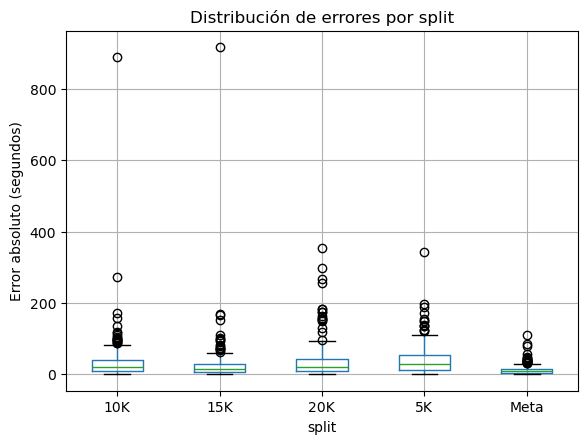

<Figure size 600x500 with 0 Axes>

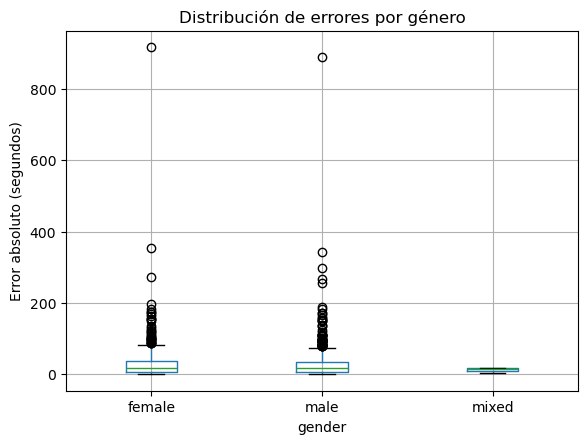

<Figure size 800x500 with 0 Axes>

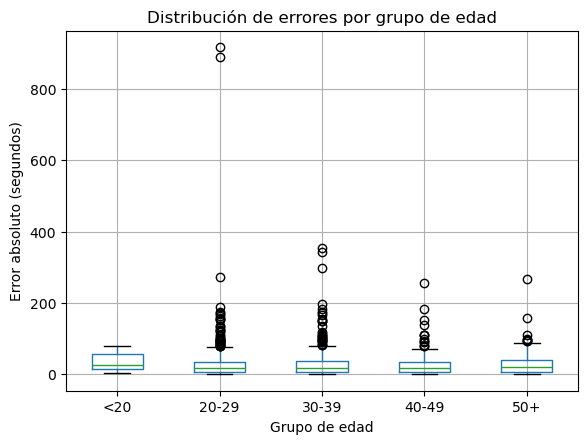

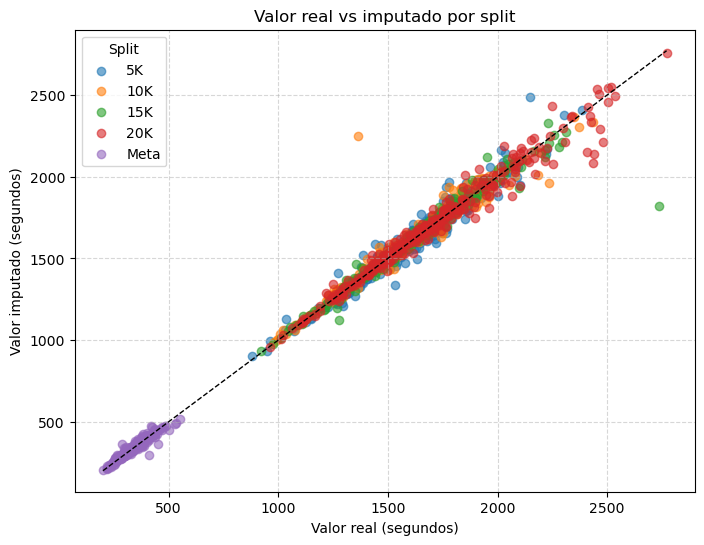

In [51]:
mae_scaled, mae_seconds, examples_min, mae_per_split = imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, athletes_df, nan_fraction=0.05, race_id_filter='2fa6d70a-afef-4f4e-880e-deea01248d9b'
)

Podemos ver que para una media maratón, los splits que mejor predice son los finales. Eso tiene sentido ya que cuanbdo un atleta ha avanzado lo suficiente en una carrera ya se van separando de forma más precisa en grupos y clusters de rendimiento, pero al principio hay un poco de caos (no se sabe si su marcha será la de toda la carrera)

También vemos como los atletas jóvenes no tienen mucha variación en su error de imputación, aunque puede ser que se deba a que no tenemos muchos ejemplos de atletas así. 

In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def imputacion_knn_maraton(athletes_events_df, athletes_time_df, athletes_df, nan_fraction=0.05, race_id_filter=None):
    # -------------------------------
    # 1️⃣ Filtrado de eventos válidos
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(['media', 'maraton']))
    ][['athlete_id', 'event_id', 'event_std', 'race_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]

    # -------------------------------
    # 2️⃣ Merge con athletes_time_df
    df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id'], how='inner')

    # 2️⃣b Merge con atletas para info descriptiva
    df_merged = df_merged.merge(athletes_df[['athlete_id', 'gender', 'birthdate']], on='athlete_id', how='left')

    # -------------------------------
    # 3️⃣ Selección de columnas existentes
    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'event_std', 'time_split_sec',
                    'split', 'rawTime', 'gender', 'birthdate']
    # Asegurarse de seleccionar solo columnas que realmente existen
    cols_to_keep = [c for c in cols_to_keep if c in df_merged.columns]

    df_subset = df_merged[cols_to_keep].copy()
    df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'rawTime', 'birthdate'])
    
    # -------------------------------
    # 4️⃣ Filtrado opcional por carrera
    if race_id_filter is not None:
        df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
        logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_subset)}")
    
    # -------------------------------
    # 5️⃣ Pivot a formato ancho (splits como columnas) y añadir info descriptiva
    df_wide = df_subset.pivot_table(index=['athlete_id', 'race_id', 'event_id'], 
                                    columns='split', values='time_split_sec')
    df_wide.reset_index(inplace=True)  # ahora race_id vuelve a ser columna

    
    # Agregar info descriptiva del atleta
    athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'rawTime']].reset_index()
    athletes_info['birthdate'] = pd.to_datetime(athletes_info['birthdate'])
    athletes_info['race_date'] = pd.to_datetime(athletes_info['rawTime'])
    athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
    df_wide = df_wide.merge(athletes_info[['athlete_id', 'gender', 'age']], on='athlete_id', how='left')
    
    # -------------------------------
    # 6️⃣ Estandarización de splits
    splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']
    scaler = StandardScaler()
    df_scaled = df_wide.copy()
    df_scaled[splits_to_keep] = scaler.fit_transform(df_wide[splits_to_keep])
    df_scaled_filtered = df_scaled.dropna().copy()
    
    # -------------------------------
    # 7️⃣ Introducir NaNs artificiales
    n_missing = int(nan_fraction * len(df_scaled_filtered))
    rows_to_nan = np.random.choice(df_scaled_filtered.index, size=n_missing, replace=False)
    for row in rows_to_nan:
        available_cols = df_scaled_filtered.loc[row, splits_to_keep].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            df_scaled_filtered.loc[row, col_to_nan] = np.nan
    
    # -------------------------------
    # 8️⃣ Imputación KNN
    imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
    df_imputed = df_scaled_filtered.copy()
    df_imputed[splits_to_keep] = imputer.fit_transform(df_scaled_filtered[splits_to_keep])
    
    # -------------------------------
    # 9️⃣ Comparación valores reales vs imputados
    comparison = pd.DataFrame(columns=['athlete_id', 'split', 'valor_real', 'valor_imputado', 'abs_error'])
    for split in splits_to_keep:
        real = df_scaled_filtered[split]
        imp = df_imputed[split]
        mask = real.isna()  # solo filas que tenían NaN artificial
        temp = pd.DataFrame({
            'athlete_id': df_scaled_filtered.index,
            'split': split,
            'valor_real': real,
            'valor_imputado': imp,
            'abs_error': (imp - real).abs()
        })
        comparison = pd.concat([comparison, temp])
    
    # Agregar info descriptiva
    comparison = comparison.merge(df_scaled_filtered[['gender','age']], left_on='athlete_id', right_index=True, how='left')
    
    # -------------------------------
    # 10️⃣ Eliminamos cualquier NaN
    comparison = comparison.dropna()
    
    # MAE general
    mae_overall = comparison['abs_error'].mean()
    
    # MAE por split
    mae_per_split = comparison.groupby('split')['abs_error'].mean().to_dict()
    print("MAE por split:", mae_per_split)
    
    # -------------------------------
    # Gráficos
    # Error por split
    plt.figure(figsize=(8,5))
    comparison.boxplot(column='abs_error', by='split')
    plt.ylabel('Error absoluto (escala)')
    plt.title('Distribución de errores por split')
    plt.suptitle('')
    plt.show()
    
    # Error por género
    plt.figure(figsize=(6,5))
    comparison.boxplot(column='abs_error', by='gender')
    plt.ylabel('Error absoluto (escala)')
    plt.title('Distribución de errores por género')
    plt.suptitle('')
    plt.show()
    
    # Error por grupos de edad
    bins = [0,20,30,40,50,100]
    labels = ['<20','20-29','30-39','40-49','50+']
    comparison['age_group'] = pd.cut(comparison['age'], bins=bins, labels=labels)
    
    plt.figure(figsize=(8,5))
    comparison.boxplot(column='abs_error', by='age_group')
    plt.ylabel('Error absoluto (escala)')
    plt.xlabel('Grupo de edad')
    plt.title('Distribución de errores por grupo de edad')
    plt.suptitle('')
    plt.show()

    # -------------------------------
    # 15️⃣ Gráfico scatter: valor real vs imputado en segundos
    plt.figure(figsize=(8,6))
    for split in splits_to_keep:
        subset = comparison[comparison['split'] == split]
        plt.scatter(subset['valor_real'], subset['valor_imputado'], alpha=0.6, label=split)

    plt.plot([comparison['valor_real'].min(), comparison['valor_real'].max()],
            [comparison['valor_real'].min(), comparison['valor_real'].max()],
            'k--', linewidth=1)  # Línea diagonal y=x para referencia
    plt.xlabel('Valor real (segundos)')
    plt.ylabel('Valor imputado (segundos)')
    plt.title('Valor real vs imputado por split')
    plt.legend(title='Split')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    
    return df_imputed, comparison, mae_per_split, mae_overall

Vemos cómo en la parte inicial y final de la carrera se d¡suelen cometer más errores por la forma del gráfico

Podemos ver como en la gran mayoría de los splits hay una error cercano al medio minuto

### pruebas

In [54]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


def evaluar_knn(df_scaled, scaler, params, nan_fraction=0.05, random_state=42):
    df_original = df_scaled.copy()
    df_missing = df_scaled.copy()
    np.random.seed(random_state)

    n_rows = len(df_missing)
    n_nan_rows = max(1, int(nan_fraction * n_rows))
    rows_nan = np.random.choice(df_missing.index, size=n_nan_rows, replace=False)

    for row in rows_nan:
        col = np.random.choice(df_missing.columns)
        df_missing.loc[row, col] = np.nan

    imputer = KNNImputer(**params)
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_missing),
        index=df_missing.index,
        columns=df_missing.columns
    )

    df_original_sec = pd.DataFrame(
        scaler.inverse_transform(df_original),
        index=df_original.index,
        columns=df_original.columns
    )
    df_imputed_sec = pd.DataFrame(
        scaler.inverse_transform(df_imputed),
        index=df_imputed.index,
        columns=df_imputed.columns
    )

    mask_missing = df_missing.isna()
    dif = (df_original_sec[mask_missing] - df_imputed_sec[mask_missing]).abs()
    mae = dif.stack().mean()

    return mae


def plot_imputation_errors(df_original, df_imputed, mask_missing, title="Errores de imputación"):
    y_true = df_original[mask_missing].stack()
    y_pred = df_imputed[mask_missing].stack()
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Valor real (s)")
    plt.ylabel("Valor imputado (s)")
    plt.title(title)
    plt.grid(True)
    plt.show()


def imputacion_knn_maraton(athletes_events_df, athletes_time_df, athletes_df,
                           nan_fraction=0.05, race_id_filter=None,
                           event_std=["media", "maraton"]):

    
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(event_std))
    ][['athlete_id', 'event_id', 'race_id']]

    
    athletes_time_df['rawTime'] = pd.to_datetime(athletes_time_df['rawTime'])
    race_dates = athletes_time_df.groupby('race_id')['rawTime'].min().reset_index()
    race_dates.rename(columns={'rawTime': 'race_date'}, inplace=True)

    merged_df = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id', 'race_id'], how='inner')
    merged_df = merged_df.merge(race_dates, on='race_id', how='left')

    athletes_df['birthdate'] = pd.to_datetime(athletes_df['birthdate'])
    merged_df = merged_df.merge(athletes_df[['athlete_id', 'birthdate']], on='athlete_id', how='left')

    merged_df['age_at_race'] = (merged_df['race_date'] - merged_df['birthdate']).dt.total_seconds() / (365.25*24*3600)

    
    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'age_at_race']
    df_subset = merged_df[cols_to_keep]
    df_subset = df_subset[df_subset['split'] != 'Salida'].copy()
    df_subset = df_subset.dropna(subset=['time_split_sec'])

    if race_id_filter is not None:
        df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
        logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_subset)}")

    
    df_wide = df_subset.pivot(index=['athlete_id', 'race_id', 'event_id', 'age_at_race'],
                              columns='split', values='time_split_sec')
    
    splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']
    df_wide = df_wide[splits_to_keep]

    
    split_distances = {'5K': 5, '10K': 10, '15K': 15, '20K': 20, 'Meta': 42.195}
    df_velocity = df_wide.copy()
    for split in splits_to_keep:
        df_velocity[split + '_vel_kmh'] = split_distances[split] / (df_wide[split] / 3600)  # seg → horas

    vel_cols = [c for c in df_velocity.columns if '_vel_kmh' in c]
    df_velocity['split_consistency_std'] = df_velocity[vel_cols].std(axis=1)

    
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_wide),
                             index=df_wide.index, columns=df_wide.columns)
    df_scaled_clean = df_scaled.dropna().copy()


    param_grid = {"n_neighbors": [3,5,7,10,15], "weights": ["uniform","distance"], "metric": ["nan_euclidean"]}
    best_mae = float("inf")
    best_params = None
    for k in param_grid["n_neighbors"]:
        for w in param_grid["weights"]:
            for m in param_grid["metric"]:
                params = {"n_neighbors": k, "weights": w, "metric": m}
                mae = evaluar_knn(df_scaled_clean, scaler, params, nan_fraction=nan_fraction)
                if mae < best_mae:
                    best_mae = mae
                    best_params = params

    logging.info(f"Mejores parámetros KNN: {best_params}, MAE tuning: {best_mae:.2f} s")


    df_missing = df_scaled_clean.copy()
    np.random.seed(42)
    n_rows = len(df_missing)
    n_nan_rows = max(1, int(nan_fraction * n_rows))
    rows_nan = np.random.choice(df_missing.index, size=n_nan_rows, replace=False)
    for row in rows_nan:
        col = np.random.choice(df_missing.columns)
        df_missing.loc[row, col] = np.nan


    imputer = KNNImputer(**best_params)
    df_imputed = pd.DataFrame(imputer.fit_transform(df_missing),
                              index=df_missing.index, columns=df_missing.columns)


    df_original_sec = pd.DataFrame(scaler.inverse_transform(df_scaled_clean),
                                   index=df_scaled_clean.index, columns=df_scaled_clean.columns)
    df_imputed_sec = pd.DataFrame(scaler.inverse_transform(df_imputed),
                                  index=df_missing.index, columns=df_missing.columns)

    mask_missing = df_missing.isna()
    mae_seconds = (df_original_sec[mask_missing] - df_imputed_sec[mask_missing]).abs().stack().mean()

    mae_per_split = {}
    ejemplos_por_split = {}
    for split in df_missing.columns:
        mae_per_split[split] = (df_original_sec[split][mask_missing[split]] -
                                df_imputed_sec[split][mask_missing[split]]).abs().mean()
        df_split = pd.DataFrame({'athlete_id': df_missing.index,
                                 'abs_error': (df_original_sec[split] - df_imputed_sec[split]).abs()})
        df_split = df_split[mask_missing[split]]
        ejemplos_por_split[split] = df_split.sort_values('abs_error', ascending=False).head(5).reset_index(drop=True)


    plot_imputation_errors(df_original_sec, df_imputed_sec, mask_missing)

    return best_mae, mae_seconds, ejemplos_por_split, mae_per_split, best_params, df_velocity

INFO: Filtrado por race_id=2fa6d70a-afef-4f4e-880e-deea01248d9b, filas restantes: 131913
INFO: Mejores parámetros KNN: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'nan_euclidean'}, MAE tuning: 27.01 s


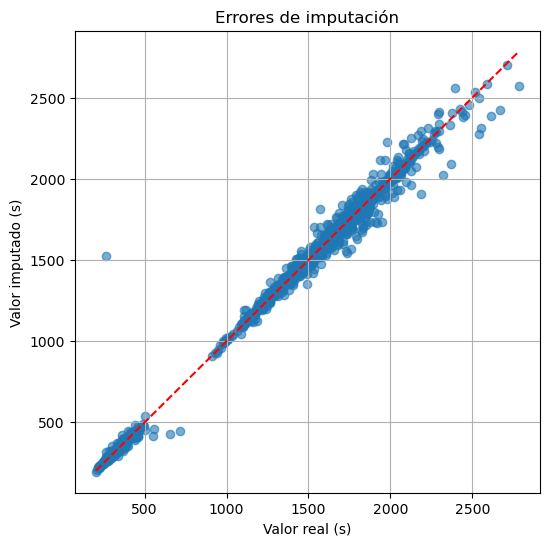

In [55]:
best_mae, mae_seconds, ejemplos_por_split, mae_per_split, best_params, df_velocity = imputacion_knn_maraton(athletes_events_df, athletes_time_df, athletes_df, nan_fraction=0.05, race_id_filter='2fa6d70a-afef-4f4e-880e-deea01248d9b', event_std=["media"])

### pruebas

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def imputacion_knn_maraton(
    athletes_events_df, 
    athletes_time_df, 
    nan_fraction=0.05, 
    race_id_filter=None,
    event_id_filter=None
):
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(['media', 'maraton']))
    ]
    events_subset = filtered_events[['athlete_id', 'event_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]

    merged_df = athletes_time_df.merge(events_subset, on=['athlete_id', 'event_id'], how='inner')

    cols_to_keep = ['athlete_id', 'event_id', 'event_std', 'race_id', 
                    'time_split_sec', 'prev_split', 'distance', 'split']
    df_subset = merged_df[cols_to_keep]
    df_subset = df_subset[df_subset['split'] != 'Salida'].copy()
    df_subset = df_subset.dropna(subset=['time_split_sec'])

    if race_id_filter is not None and event_id_filter is not None:
        df_subset = df_subset[
            (df_subset['race_id'] == race_id_filter) &
            (df_subset['event_id'] == event_id_filter)
        ].copy()
        logging.info(f"Filtrado por race_id={race_id_filter} y event_id={event_id_filter}, filas restantes: {len(df_subset)}")
        splits_to_keep = df_subset['split'].unique().tolist()
        logging.info(f"Splits disponibles dinámicamente: {splits_to_keep}")
    else:
        splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']
        logging.info(f"No se filtra por carrera/evento, usando splits por defecto: {splits_to_keep}")

    df_wide = df_subset.pivot(index=['athlete_id', 'race_id', 'event_id'], 
                              columns='split', values='time_split_sec')
    logging.info(f"df_wide shape: {df_wide.shape}, filas con NaN: {df_wide.isna().any(axis=1).sum()}")
    df_wide_filtered_1 = df_wide.copy()

    scaler_filtered = StandardScaler()
    df_scaled_filtered = pd.DataFrame(
        scaler_filtered.fit_transform(df_wide[splits_to_keep]),
        index=df_wide.index,
        columns=splits_to_keep
    )
    df_wide_filtered = df_scaled_filtered.dropna().copy()

    n_missing = int(nan_fraction * len(df_wide_filtered))
    rows_to_nan = np.random.choice(df_wide_filtered.index, size=n_missing, replace=False)
    for row in rows_to_nan:
        available_cols = df_wide_filtered.loc[row].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            df_wide_filtered.loc[row, col_to_nan] = np.nan

    imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_wide_filtered),
        index=df_wide_filtered.index,
        columns=df_wide_filtered.columns
    )


    df1_scaled = df_wide_filtered.copy()
    df2_scaled = df_wide_filtered_1[splits_to_keep].loc[df1_scaled.index] 

    mask_stack_scaled = df1_scaled.isna().stack() & df2_scaled.stack().notna()
    original_values_only_scaled = df2_scaled.stack()[mask_stack_scaled]
    imputed_values_only_scaled = df_imputed.stack()[mask_stack_scaled]

    comparison_scaled = pd.DataFrame({
        'valor_real_scaled': original_values_only_scaled,
        'valor_imputado_scaled': imputed_values_only_scaled
    })
    comparison_scaled['abs_error_scaled'] = (comparison_scaled['valor_imputado_scaled'] - comparison_scaled['valor_real_scaled']).abs()
    mae_scaled = comparison_scaled['abs_error_scaled'].mean()

    plt.figure(figsize=(6, 6))
    plt.scatter(comparison_scaled["valor_real_scaled"], comparison_scaled["valor_imputado_scaled"], alpha=0.5)
    plt.xlabel("Valor real (escalado)")
    plt.ylabel("Valor imputado (escalado)")
    plt.title("Comparación valores reales vs imputados (KNN) en escala")
    min_val = min(comparison_scaled["valor_real_scaled"].min(), comparison_scaled["valor_imputado_scaled"].min())
    max_val = max(comparison_scaled["valor_real_scaled"].max(), comparison_scaled["valor_imputado_scaled"].max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red")
    plt.grid()
    plt.tight_layout()
    plt.show()


    df_imputed_seconds = pd.DataFrame(
        scaler_filtered.inverse_transform(df_imputed),
        index=df_imputed.index,
        columns=df_imputed.columns
    )
    df_original_seconds = pd.DataFrame(
        scaler_filtered.inverse_transform(df_wide_filtered_1[splits_to_keep].loc[df_imputed.index]),
        index=df_imputed.index,
        columns=splits_to_keep
    )

    original_stack_sec = df_original_seconds.stack()
    imputed_stack_sec = df_imputed_seconds.stack()
    mask_stack_sec = df1_scaled.isna().stack() & original_stack_sec.notna()
    original_values_only_sec = original_stack_sec[mask_stack_sec]
    imputed_values_only_sec = imputed_stack_sec[mask_stack_sec]

    comparison_sec = pd.DataFrame({
        'split': original_values_only_sec.index.get_level_values(2),
        'valor_real_sec': original_values_only_sec.values,
        'valor_imputado_sec': imputed_values_only_sec.values
    })
    comparison_sec['abs_error_sec'] = (comparison_sec['valor_imputado_sec'] - comparison_sec['valor_real_sec']).abs()
    mae_seconds = comparison_sec['abs_error_sec'].mean()

    plt.figure(figsize=(6, 6))
    plt.scatter(comparison_sec["valor_real_sec"] / 60, comparison_sec["valor_imputado_sec"] / 60, alpha=0.5)
    plt.xlabel("Valor real (minutos)")
    plt.ylabel("Valor imputado (minutos)")
    plt.title("Comparación valores reales vs imputados (KNN) en segundos")
    max_val_min = max(comparison_sec["valor_real_sec"].max(), comparison_sec["valor_imputado_sec"].max()) / 60
    plt.plot([0, max_val_min], [0, max_val_min], linestyle="--", color="red")
    plt.grid()
    plt.tight_layout()
    plt.show()

    
    def sec_to_hhmmss(x):
        return pd.to_timedelta(x, unit="s")

    ejemplos_por_split = {}
    for split in splits_to_keep:
        df_split = comparison_sec[comparison_sec['split'] == split].copy()
        if len(df_split) >= 5:
            df_sample = df_split.sample(5, random_state=42)
        else:
            df_sample = df_split.copy()
        df_sample['real_hhmmss'] = df_sample['valor_real_sec'].apply(sec_to_hhmmss)
        df_sample['imputado_hhmmss'] = df_sample['valor_imputado_sec'].apply(sec_to_hhmmss)
        ejemplos_por_split[split] = df_sample[['valor_real_sec', 'valor_imputado_sec', 'real_hhmmss', 'imputado_hhmmss']].reset_index(drop=True)

    mae_per_split = {split: comparison_sec.loc[comparison_sec['split']==split, 'abs_error_sec'].mean() 
                     for split in splits_to_keep}

    print("MAE por split calculado:", mae_per_split)

    return mae_scaled, mae_seconds, ejemplos_por_split, mae_per_split